# Alumno: Luis Clemente Michicol Martinez

Title: Monthly Tesla Stock Prices (01/01/2015 - 17/01/2024)

Uploaded by: Jillani SoftTech

Context:
This dataset provides a comprehensive view of Tesla's stock performance over a significant period, from January 1, 2015, to January 17, 2024. It serves as a valuable resource for data scientists, financial analysts, and enthusiasts interested in understanding market trends, performing time series analysis, and predicting future stock movements.

Content:
The dataset contains monthly stock price data for Tesla, Inc. It is structured into seven columns, detailing the date of the record and six key stock indicators:

    Date: The date of the stock record.
    Open: The opening price of Tesla's stock for the month.
    High: The highest price reached by Tesla's stock in the month.
    Low: The lowest price of Tesla's stock in the month.
    Close: The closing price of Tesla's stock for the month.
    Volume: The total trading volume of Tesla's stock for the month.

Esta base de datos, se puede enconter en https://www.kaggle.com/datasets/jillanisofttech/tesla-stock-price

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

2025-04-11 22:57:47.184727: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 22:57:47.304637: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 22:57:51.467208: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('TSLA.csv')

In [3]:
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-09-30,48.796001,47.222000,48.599998,48.174000,29399000.0,48.174000
1,2019-10-01,49.189999,47.826000,48.299999,48.938000,30813000.0,48.938000
2,2019-10-02,48.930000,47.886002,48.658001,48.625999,28157000.0,48.625999
3,2019-10-03,46.896000,44.855999,46.372002,46.605999,75422500.0,46.605999
4,2019-10-04,46.956001,45.613998,46.321999,46.285999,39975000.0,46.285999
...,...,...,...,...,...,...,...
634,2022-04-05,1152.869995,1087.300049,1136.300049,1091.260010,26691700.0,1091.260010
635,2022-04-06,1079.000000,1027.699951,1073.469971,1045.760010,29782800.0,1045.760010
636,2022-04-07,1076.589966,1021.539978,1052.390015,1057.260010,26482400.0,1057.260010
637,2022-04-08,1048.439941,1022.440002,1043.209961,1025.489990,18293300.0,1025.489990


In [4]:
df.isna().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

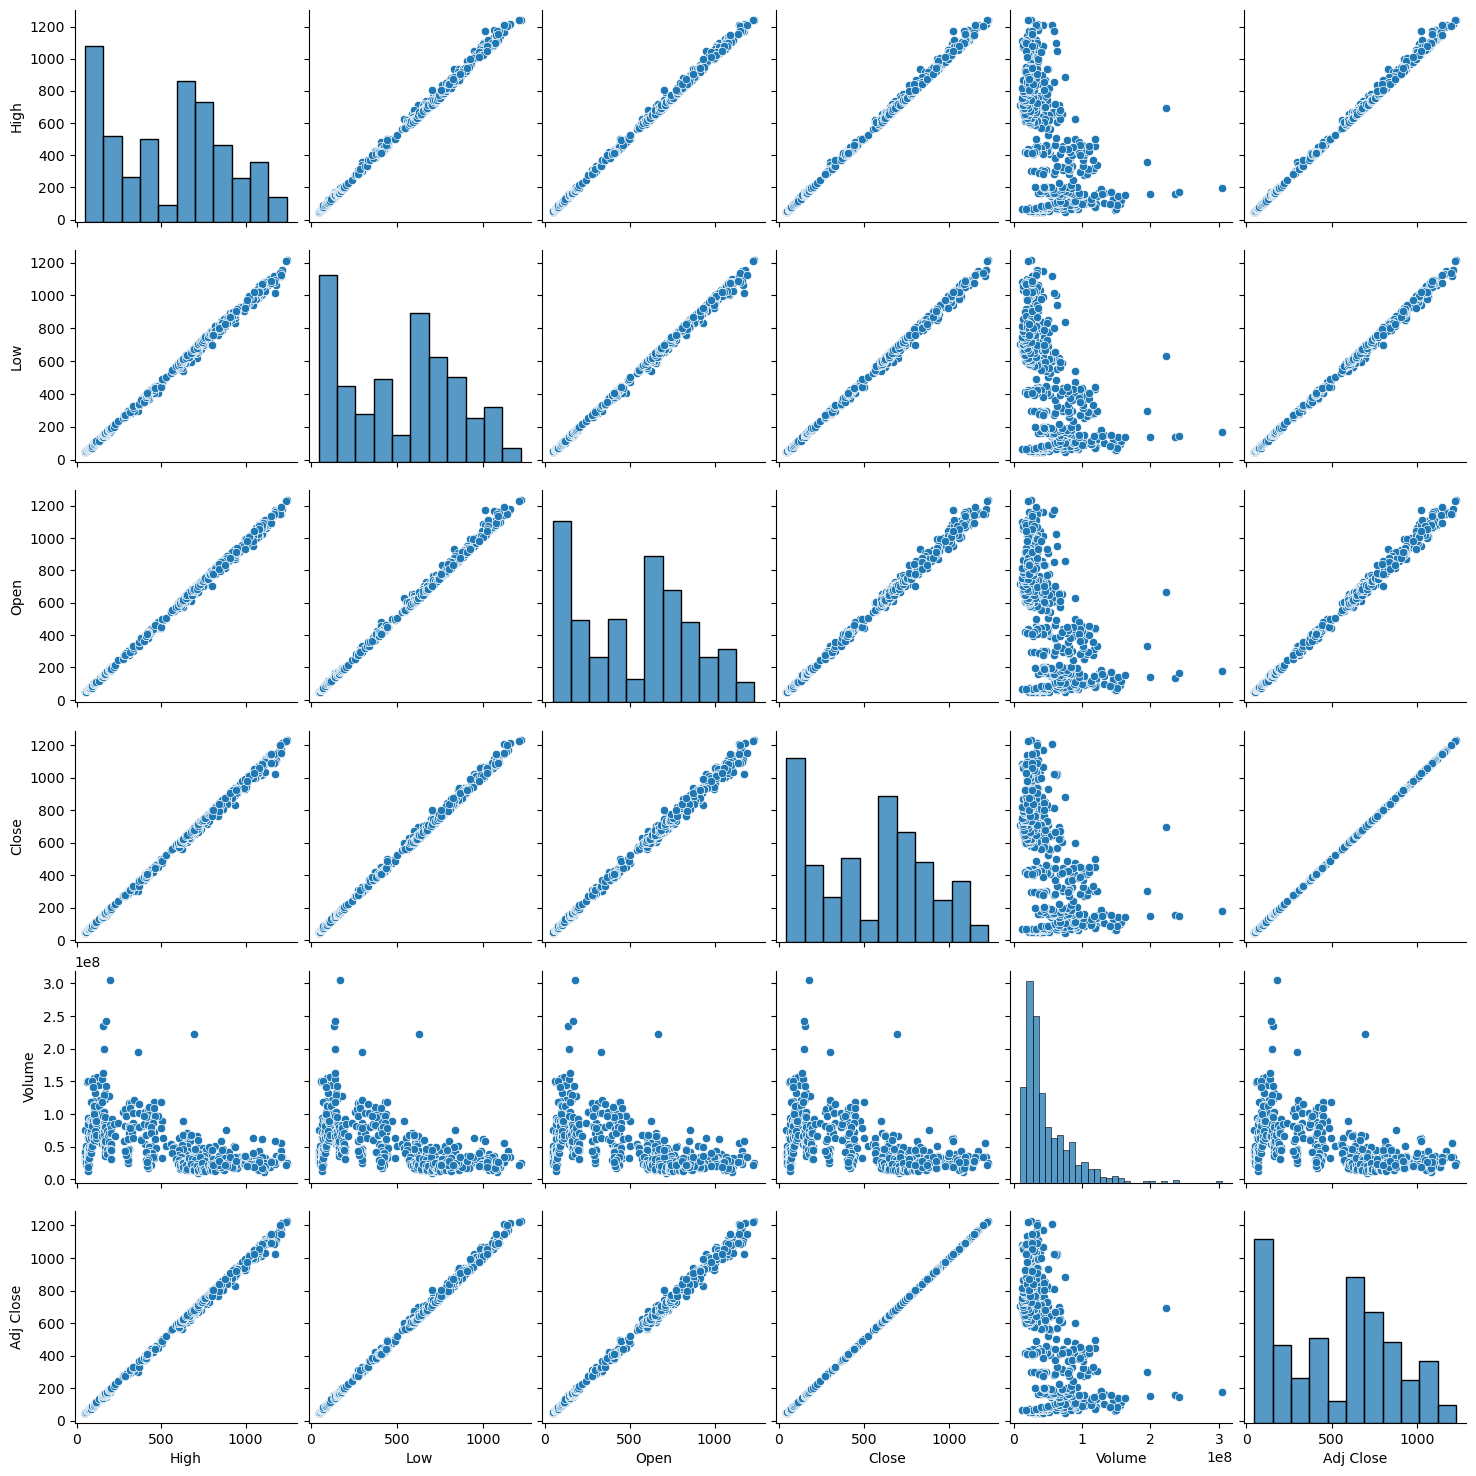

In [5]:
sns.pairplot(df)

<Axes: xlabel='Date'>

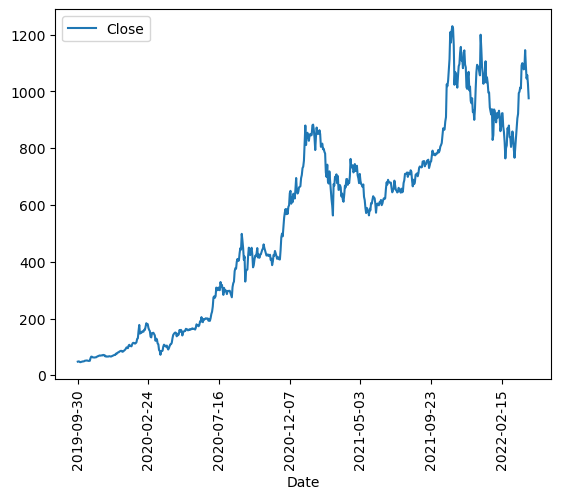

In [6]:
df.plot(
    'Date',
    'Close',
    rot=90
)

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Usar solo la columna 'Close'
data = df[['Close']].values

# Dividir en entrenamiento y prueba (sin barajar)
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data = data[0:train_size]
test_data = data[train_size:]

# Escalar datos (ajustar solo con entrenamiento)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Función para crear secuencias temporales
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 60  # Ventana de tiempo para predecir

# Crear secuencias de entrenamiento
X_train, y_train = create_sequences(train_scaled, look_back)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Combinar últimos días del entrenamiento con datos de prueba
test_inputs = np.concatenate([train_scaled[-look_back:], test_scaled], axis=0)

# Crear secuencias de prueba
X_test, y_test = create_sequences(test_inputs, look_back)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [8]:
# Construir modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


/home/michicol/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

In [16]:
# Entrenar el modelo
history = model.fit(
    X_train, 
    y_train, 
    epochs=125, 
    batch_size=32,
    validation_split=0.05
)

Epoch 1/125
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0018 - val_loss: 2.4570e-04
Epoch 2/125
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0018 - val_loss: 4.9539e-04
Epoch 3/125
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0020 - val_loss: 2.2197e-04
Epoch 4/125
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0014 - val_loss: 3.4434e-04
Epoch 5/125
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0019 - val_loss: 2.1827e-04
Epoch 6/125
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0016 - val_loss: 6.1190e-04
Epoch 7/125
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0019 - val_loss: 3.4083e-04
Epoch 8/125
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0016 - val_loss: 2.5141e-04
Epoch 9/125
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0016 - val_loss: 3.5042e-04
Epoch 10/125
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0017 - val_loss: 2.3765e-04
Epoch 11/125
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0018 - val_loss: 2.3816e-

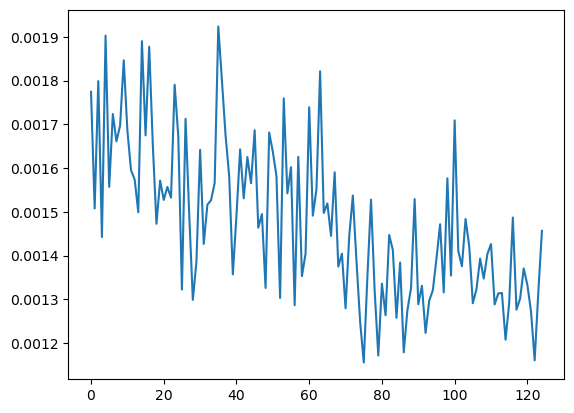

In [17]:
plt.plot(history.history['loss'])
plt.show()

In [18]:
# Hacer predicciones
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Valores reales para comparación
y_test_actual = test_data[:len(predictions)]

# Calcular RMSE
rmse = np.sqrt(np.mean((predictions - y_test_actual)**2))
print(f'RMSE: {rmse}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
RMSE: 51.58857394037579


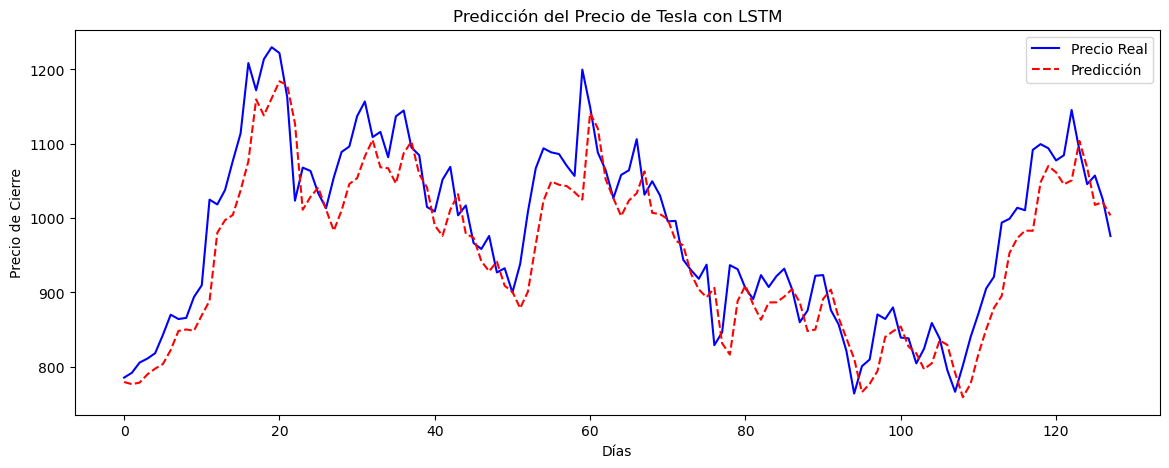

In [19]:
# Visualizar resultados
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, label='Precio Real', color='blue')
plt.plot(predictions, label='Predicción', color='red', linestyle='--')
plt.title('Predicción del Precio de Tesla con LSTM')
plt.xlabel('Días')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()